# Multi-Fidelity BO and ABC for Circulatory System Modeling

This notebook demonstrates parameter tuning for a synthetic circulatory system model using multi-fidelity Bayesian Optimization in Part A, and Approximate Posterior Estimation using ABC in Part B

**Problem Setup:**
- 5 parameters to tune: resistances (R1, R2, R3) and compliances (C1, C2)
- 4 measurements to match: 2 flows (Q1, Q2) and 2 pressures (P1, P2)
- 2 fidelity levels: low-fidelity (fast approximation) and high-fidelity (accurate simulation)
- Objective: minimize the mismatch between model predictions and target measurements

In [41]:
# Colab setup (run once per session)
# !pip -q install botorch pyDOE

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize, InputStandardize
from botorch.acquisition import LogExpectedImprovement as ExpectedImprovement
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch import fit_gpytorch_mll
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from scipy.stats import qmc

torch.manual_seed(123)
np.random.seed(123)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

## --- PART A --- Multi-fidelity BO for parameter tuning

### Define Synthetic Circulatory System Models

We create synthetic models that simulate circulatory system behavior based on resistances and compliances. **WARNING:** This is an example problem, with no true physiological meaning. More physiological non-linearities for the high-fidelity model, e.g. pressure-dependent compliance, stenotic restrictions, etc. can be added by the users themselves later.

In [43]:
# True optimal parameters (unknown to the optimizer)
TRUE_PARAMS = torch.tensor([0.6, 0.4, 0.5, 0.55, 0.45], **tkwargs)

def circulatory_model_high_fidelity(params):
    """
    Synthetic high-fidelity circulatory system model,
    with nonlinear coupling interactions between parameters/outputs.
    
    Args:
        params: [R1, R2, R3, C1, C2] - normalized to [0, 1]
    
    Returns:
        measurements: [Q1, Q2, P1, P2] - flows and pressures
    """
    # Scale parameters to realistic ranges
    R1 = params[..., 0] * 2.0 + 0.5  # Resistance 1: [0.5, 2.5]
    R2 = params[..., 1] * 2.0 + 0.5  # Resistance 2: [0.5, 2.5]
    R3 = params[..., 2] * 2.0 + 0.5  # Resistance 3: [0.5, 2.5]
    C1 = params[..., 3] * 2.0 + 0.5  # Compliance 1: [0.5, 2.5]
    C2 = params[..., 4] * 2.0 + 0.5  # Compliance 2: [0.5, 2.5]
    
    # Simulate flows (simplified Ohm's law for flow)
    Q1 = 120.0 / (R1 + R2) - 0.5 * torch.sin(3.0 * R1) * C1
    Q2 = 80.0 / (R2 + R3) + 0.3 * torch.cos(2.0 * R3) * C2
    
    # Simulate pressures
    P1 = Q1 * R1 + 20.0 * (1.0 / C1) - 5.0 * torch.sin(R2)
    P2 = Q2 * R3 + 15.0 * (1.0 / C2) + 10.0 * torch.cos(R1 + R2)
    
    # Add nonlinear coupling effects
    Q1 = Q1 + 0.2 * torch.exp(-0.5 * (R1 - 1.5)**2) * C2
    Q2 = Q2 - 0.15 * torch.exp(-0.5 * (R3 - 1.5)**2) * C1
    P1 = P1 + 3.0 * torch.sin(C1 + C2)
    P2 = P2 + 2.5 * torch.cos(C1 * C2)
    
    return torch.stack([Q1, Q2, P1, P2], dim=-1)

def circulatory_model_low_fidelity(params):
    """
    Low-fidelity circulatory system model (faster but less accurate).
    Simplified version without nonlinear coupling.
    """
    # Scale parameters
    R1 = params[..., 0] * 2.0 + 0.5
    R2 = params[..., 1] * 2.0 + 0.5
    R3 = params[..., 2] * 2.0 + 0.5
    C1 = params[..., 3] * 2.0 + 0.5
    C2 = params[..., 4] * 2.0 + 0.5
    
    # Simplified flows (linear approximation)
    Q1 = 110.0 / (R1 + R2) - 0.3 * R1 * C1
    Q2 = 75.0 / (R2 + R3) + 0.2 * R3 * C2
    
    # Simplified pressures
    P1 = Q1 * R1 + 18.0 * (1.0 / C1)
    P2 = Q2 * R3 + 14.0 * (1.0 / C2) + 8.0
    
    return torch.stack([Q1, Q2, P1, P2], dim=-1)

def circulatory_model_multifidelity(params_with_fidelity):
    """
    Multi-fidelity model with linear interpolation between fidelities.
    
    Args:
        params_with_fidelity: [..., R1, R2, R3, C1, C2, C3, s]
        params_with_fidelity: [..., R1, R2, R3, C1, C2, s]
    """
    params = params_with_fidelity[..., :-1]  # Extract parameters
    s = params_with_fidelity[..., -1:]  # Extract fidelity
    
    measurements_low = circulatory_model_low_fidelity(params)
    measurements_high = circulatory_model_high_fidelity(params)
    
    # Linear interpolation
    return (1 - s) * measurements_low + s * measurements_high

# Compute target measurements using true parameters
true_params_with_fidelity = torch.cat([TRUE_PARAMS, torch.ones(1, **tkwargs)], dim=0)
target_measurements = circulatory_model_multifidelity(true_params_with_fidelity)

print("Target Measurements:")
print(f"  Q1 (Flow 1): {target_measurements[0].item():.3f} L/min")
print(f"  Q2 (Flow 2): {target_measurements[1].item():.3f} L/min")
print(f"  P1 (Pressure 1): {target_measurements[2].item():.3f} mmHg")
print(f"  P2 (Pressure 2): {target_measurements[3].item():.3f} mmHg")
print(f"\nTrue parameters: {TRUE_PARAMS.numpy()}")

Target Measurements:
  Q1 (Flow 1): 41.015 L/min
  Q2 (Flow 2): 27.916 L/min
  P1 (Pressure 1): 77.365 mmHg
  P2 (Pressure 2): 41.497 mmHg

True parameters: [0.6  0.4  0.5  0.55 0.45]


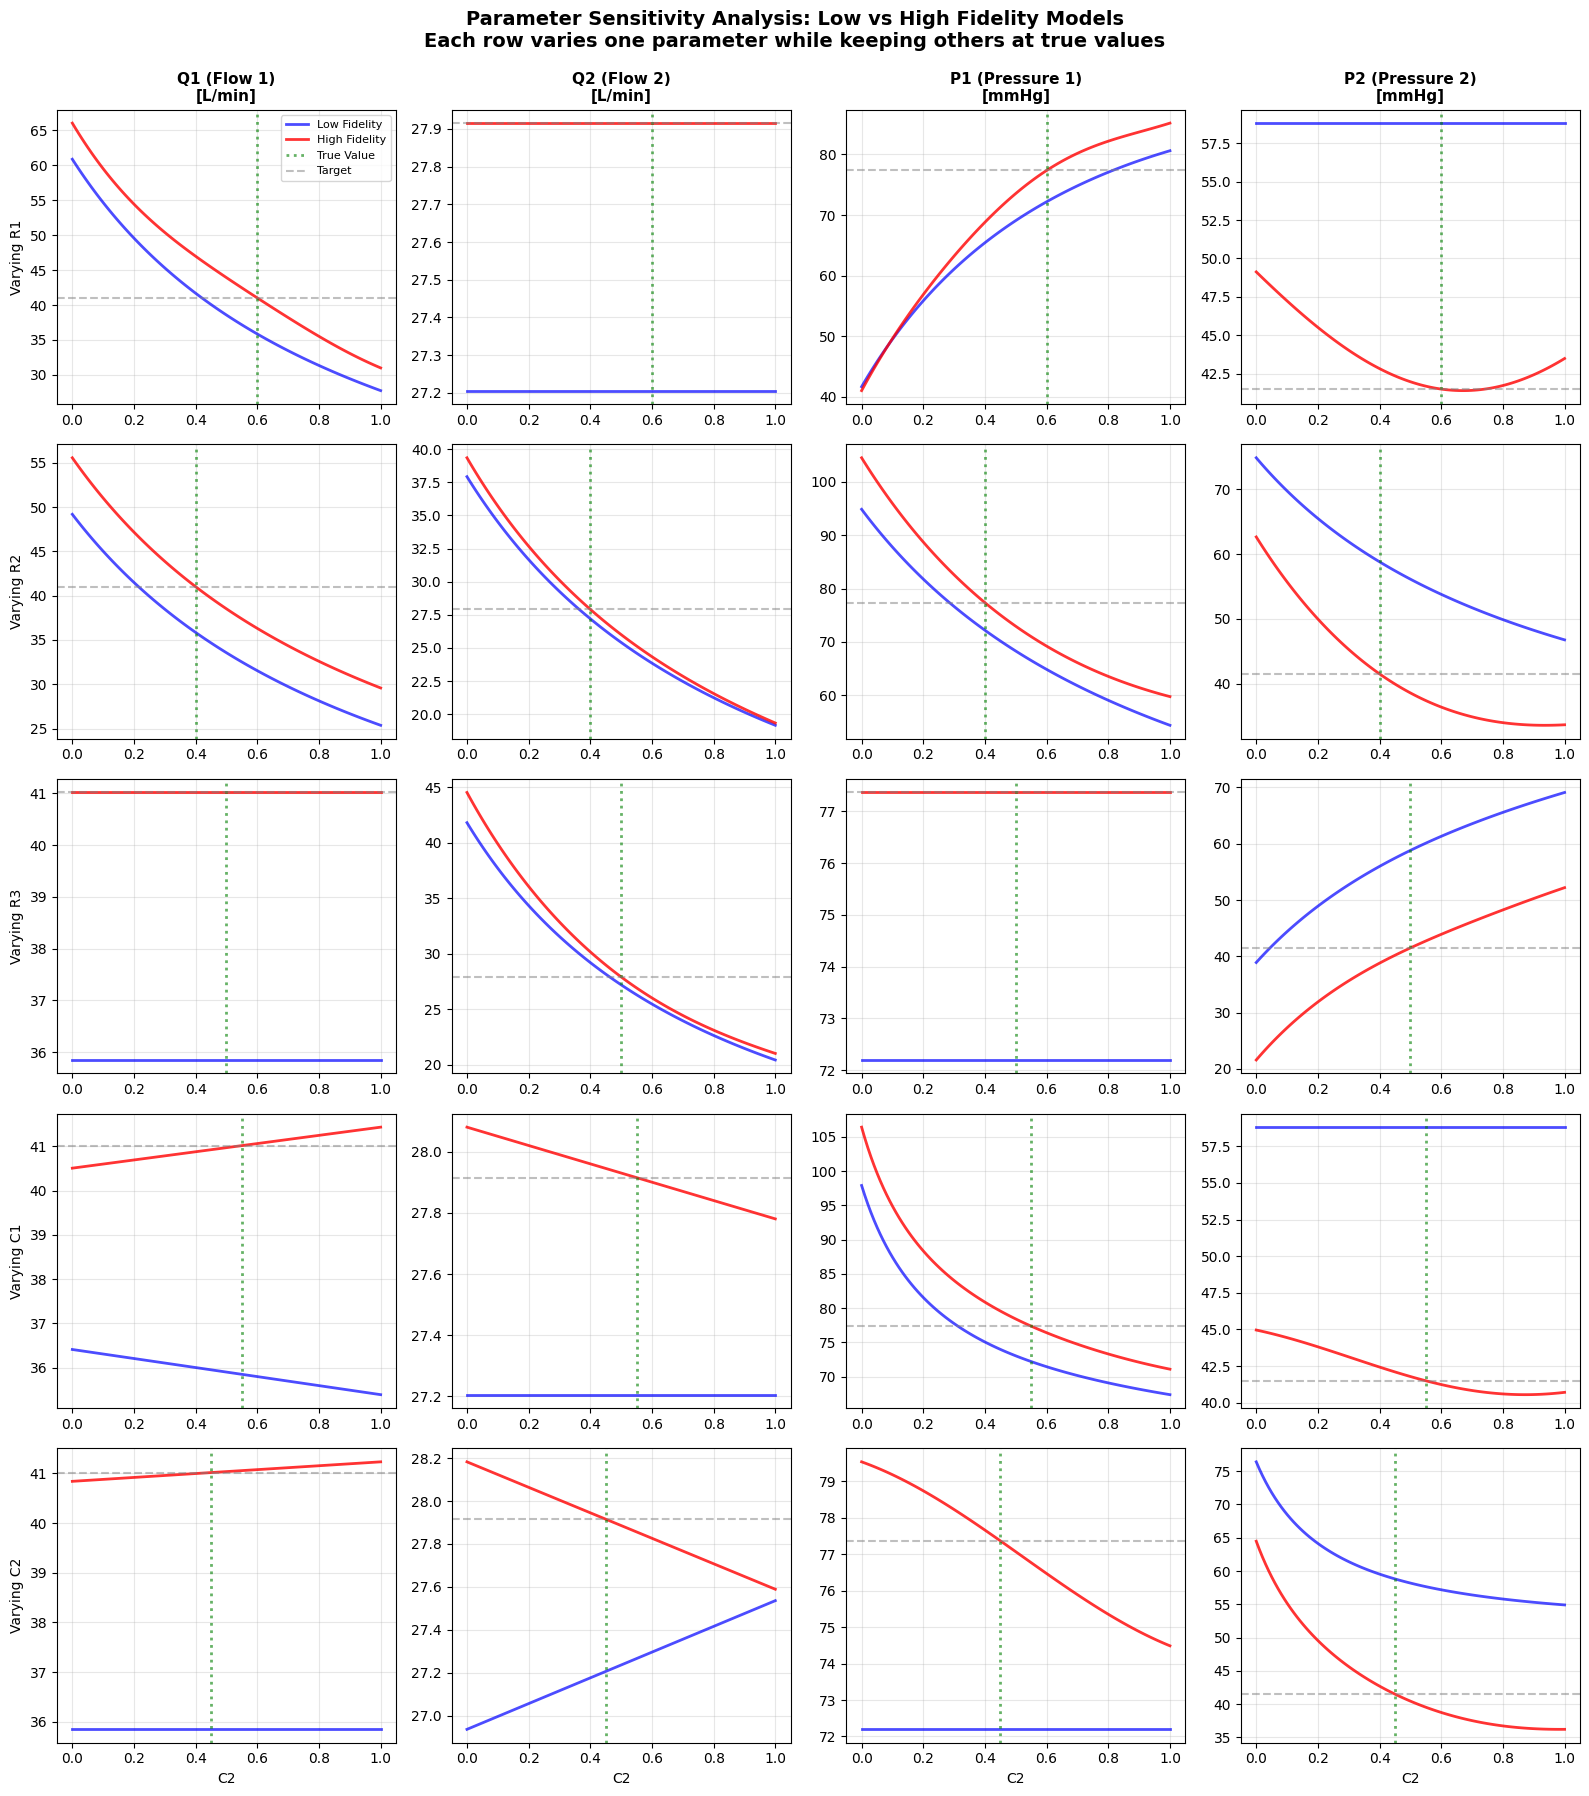

In [44]:
# Visualize low and high fidelity functions for each parameter-output pair
fig, axes = plt.subplots(5, 4, figsize=(16, 18))

# Use the true parameters as the baseline
baseline_params = TRUE_PARAMS.clone()

# Create parameter sweep range
n_points = 100
param_range = torch.linspace(0, 1, n_points, **tkwargs)

# Parameter and measurement names
param_names = ['R1', 'R2', 'R3', 'C1', 'C2']
output_names = ['Q1 (Flow 1)', 'Q2 (Flow 2)', 'P1 (Pressure 1)', 'P2 (Pressure 2)']
output_units = ['L/min', 'L/min', 'mmHg', 'mmHg']

# Loop through each parameter
for param_idx in range(5):
    # Loop through each output
    for output_idx in range(4):
        ax = axes[param_idx, output_idx]
        
        # Storage for low and high fidelity predictions
        low_fidelity_outputs = []
        high_fidelity_outputs = []
        
        # Sweep the parameter
        for val in param_range:
            # Create parameter vector with one parameter varied
            params_varied = baseline_params.clone()
            params_varied[param_idx] = val
            
            # Low fidelity
            params_low = torch.cat([params_varied, torch.tensor([0.0], **tkwargs)])
            output_low = circulatory_model_multifidelity(params_low)
            low_fidelity_outputs.append(output_low[output_idx].item())
            
            # High fidelity
            params_high = torch.cat([params_varied, torch.tensor([1.0], **tkwargs)])
            output_high = circulatory_model_multifidelity(params_high)
            high_fidelity_outputs.append(output_high[output_idx].item())
        
        # Plot
        ax.plot(param_range.numpy(), low_fidelity_outputs, 'b-', 
                linewidth=2, label='Low Fidelity', alpha=0.7)
        ax.plot(param_range.numpy(), high_fidelity_outputs, 'r-', 
                linewidth=2, label='High Fidelity', alpha=0.8)
        
        # Mark the true parameter value
        ax.axvline(TRUE_PARAMS[param_idx].item(), color='green', 
                   linestyle=':', linewidth=2, label='True Value', alpha=0.6)
        
        # Mark the target measurement
        ax.axhline(target_measurements[output_idx].item(), color='gray', 
                   linestyle='--', linewidth=1.5, label='Target', alpha=0.5)
        
        # Labels and formatting
        if param_idx == 0:
            ax.set_title(f'{output_names[output_idx]}\n[{output_units[output_idx]}]', 
                        fontsize=11, fontweight='bold')
        
        if param_idx == 4:
            ax.set_xlabel(f'{param_names[param_idx]}', fontsize=10)
        
        if output_idx == 0:
            ax.set_ylabel(f'Varying {param_names[param_idx]}', fontsize=10)
        
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first subplot
        if param_idx == 0 and output_idx == 0:
            ax.legend(loc='best', fontsize=8)

plt.suptitle('Parameter Sensitivity Analysis: Low vs High Fidelity Models\n' + 
             'Each row varies one parameter while keeping others at true values',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Define Objective Function
The objective is to minimize the weighted sum of squared errors between model predictions and target measurements.

In [45]:
def objective_function(params_with_fidelity):
    """
    Compute mismatch between model predictions and target measurements.
    Returns negative MSE (since we use EI which maximizes).
    """
    predictions = circulatory_model_multifidelity(params_with_fidelity)
    
    # Weighted squared errors
    weights = torch.tensor([1.0, 1.0, 0.1, 0.1], **tkwargs)  # Flows weighted more than pressures
    
    errors = (predictions - target_measurements) ** 2
    weighted_mse = (weights * errors).mean()
    
    return -weighted_mse  # Negate for minimization

# Parameter bounds
dim = 5
# Here we assume our parameters live in the range [0,1], but this needs to be adjusted for each application
bounds = torch.tensor([[0.0] * dim, [1.0] * dim], **tkwargs)

### Generate Initial Training Data
We use Latin Hypercube Sampling for space-filling initial design.

In [ ]:
# Initial training data
n_low = 100  # Number of low-fidelity samples
n_high = 10  # Number of high-fidelity samples

# Generate low-fidelity data (s=0.0) using Latin Hypercube Sampling
# botorch needs the fidelity as the last dimension of the input.
# sampler = qmc.LatinHypercube(d=dim, seed=123)
sampler = qmc.LatinHypercube(d=dim, seed=1234)
# sampler = qmc.LatinHypercube(d=dim, seed=1313)
X_low_np = sampler.random(n=n_low)
X_low = torch.tensor(X_low_np, **tkwargs)
s_low = torch.zeros(n_low, 1, **tkwargs)
X_low_full = torch.cat([X_low, s_low], dim=1)
y_low = torch.stack([objective_function(x) for x in X_low_full])

# Generate high-fidelity data (s=1.0) using Latin Hypercube Sampling
X_high_np = sampler.random(n=n_high)
X_high = torch.tensor(X_high_np, **tkwargs)
s_high = torch.ones(n_high, 1, **tkwargs)
X_high_full = torch.cat([X_high, s_high], dim=1)
y_high = torch.stack([objective_function(x) for x in X_high_full])

# Combine training data
train_X = torch.cat([X_low_full, X_high_full], dim=0)
train_y = torch.cat([y_low, y_high], dim=0).unsqueeze(-1)

print(f"Training data shape: {train_X.shape}")
print(f"Training labels shape: {train_y.shape}")
print(f"\nInitial best high-fidelity objective: {-y_high.max().item():.6f}")
print(f"(Lower is better - this is the MSE)")

Training data shape: torch.Size([110, 6])
Training labels shape: torch.Size([110, 1])

Initial best high-fidelity objective: 21.420488
(Lower is better - this is the MSE)


### Initialize Multi-Fidelity GP Model

In [47]:
def initialize_model(train_X, train_y):
    """Initialize and fit a SingleTaskMultiFidelityGP model"""
    model = SingleTaskMultiFidelityGP(
        train_X, 
        train_y, 
        input_transform=Normalize(d=6),  # Standardize the parameter dimensions
        outcome_transform=Standardize(m=1),
        data_fidelities=[5]  # Fidelity is in dimension 5 (0-indexed)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

model = initialize_model(train_X, train_y)
print("Model initialized and fitted!")

Model initialized and fitted!


### Set Up Expected Improvement Acquisition Function

In [48]:
def get_ei(model, best_f):
    """Get Expected Improvement acquisition function fixed at high fidelity"""
    ei_acqf = ExpectedImprovement(model=model, best_f=best_f)
    
    # Fix the fidelity dimension to 1.0 (high fidelity)
    ei_acqf_fixed = FixedFeatureAcquisitionFunction(
        acq_function=ei_acqf,
        d=6,  # Total dimensions (5 params + fidelity)
        columns=[5],  # Fidelity dimension
        values=[1.0],  # Fix to high fidelity
    )
    
    return ei_acqf_fixed

### Run Bayesian Optimization Loop
We run a Bayesian optimization loop to improve the predictive capacity of our Multifidelity GP surrogate model with respect to the ground-truth data (for this tutorial only Bayesion Optimization on the high-fidelity data).

In [49]:
n_iterations = 30
cumulative_cost = 0.0
best_objectives = []
best_params_history = []

for iteration in range(n_iterations):
    print(f"\n{'='*70}")
    print(f"Iteration {iteration + 1}/{n_iterations}")
    print(f"{'='*70}")
    
    # Get best observed high-fidelity value
    high_fidelity_mask = train_X[:, 5] == 1.0
    best_f = train_y[high_fidelity_mask].max()  # max of negated values
    
    # Get EI acquisition function
    ei_acqf = get_ei(model, best_f)
    
    # Optimize EI over parameters (fidelity is fixed to 1.0)
    new_x_design, _ = optimize_acqf(
        acq_function=ei_acqf,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200},
    )
    
    # Construct full input with high fidelity in the last dimension
    new_x = ei_acqf._construct_X_full(new_x_design)
    
    # Evaluate at the new point (high fidelity only)
    new_y = objective_function(new_x[0]).unsqueeze(0).unsqueeze(-1)
    
    # Cost is 1.0 per high-fidelity evaluation
    cost = 1.0
    cumulative_cost += cost
    
    print(f"New query point:")
    print(f"  Parameters: {new_x[0, :-1].numpy()}")
    print(f"  Objective (MSE): {-new_y.item():.6f}")
    print(f"  Cost: {cost:.1f}, Cumulative cost: {cumulative_cost:.1f}")
    
    # Update training data
    train_X = torch.cat([train_X, new_x], dim=0)
    train_y = torch.cat([train_y, new_y], dim=0)
    
    # Refit model
    model = initialize_model(train_X, train_y)
    
    # Find current best at high fidelity
    high_fidelity_mask = train_X[:, 5] == 1.0
    best_y_neg = train_y[high_fidelity_mask].max()  # max of negated = min of original
    best_idx = train_y[high_fidelity_mask].argmax()
    best_x = train_X[high_fidelity_mask][best_idx, :-1]  # Exclude fidelity dimension
    
    best_objectives.append(-best_y_neg.item())
    best_params_history.append(best_x.numpy())
    
    print(f"\nCurrent best:")
    print(f"  Objective (MSE): {-best_y_neg.item():.6f}")
    print(f"  Parameters: {best_x.numpy()}")
    print(f"  True parameters: {TRUE_PARAMS.numpy()}")
    print(f"  Parameter error (L2): {torch.norm(best_x - TRUE_PARAMS).item():.6f}")

print("\n" + "="*70)
print("Optimization complete!")
print("="*70)
print(f"Total cost (high-fidelity evaluations): {cumulative_cost:.1f}")
print(f"Final best objective (MSE): {best_objectives[-1]:.6f}")
print(f"Final parameter error: {torch.norm(torch.tensor(best_params_history[-1]) - TRUE_PARAMS).item():.6f}")


Iteration 1/30
New query point:
  Parameters: [0.79046299 0.31343788 0.53332944 0.7956161  1.        ]
  Objective (MSE): 2.803018
  Cost: 1.0, Cumulative cost: 1.0

Current best:
  Objective (MSE): 2.803018
  Parameters: [0.79046299 0.31343788 0.53332944 0.7956161  1.        ]
  True parameters: [0.6  0.4  0.5  0.55 0.45]
  Parameter error (L2): 0.638520

Iteration 2/30
New query point:
  Parameters: [0.78667865 0.54082496 0.20709823 0.         0.        ]
  Objective (MSE): 43.674177
  Cost: 1.0, Cumulative cost: 2.0

Current best:
  Objective (MSE): 2.803018
  Parameters: [0.79046299 0.31343788 0.53332944 0.7956161  1.        ]
  True parameters: [0.6  0.4  0.5  0.55 0.45]
  Parameter error (L2): 0.638520

Iteration 3/30
New query point:
  Parameters: [0.2680113  0.80828851 0.         0.         0.12180786]
  Objective (MSE): 8.531603
  Cost: 1.0, Cumulative cost: 3.0

Current best:
  Objective (MSE): 2.803018
  Parameters: [0.79046299 0.31343788 0.53332944 0.7956161  1.        ]
 

### Visualize Optimization Progress

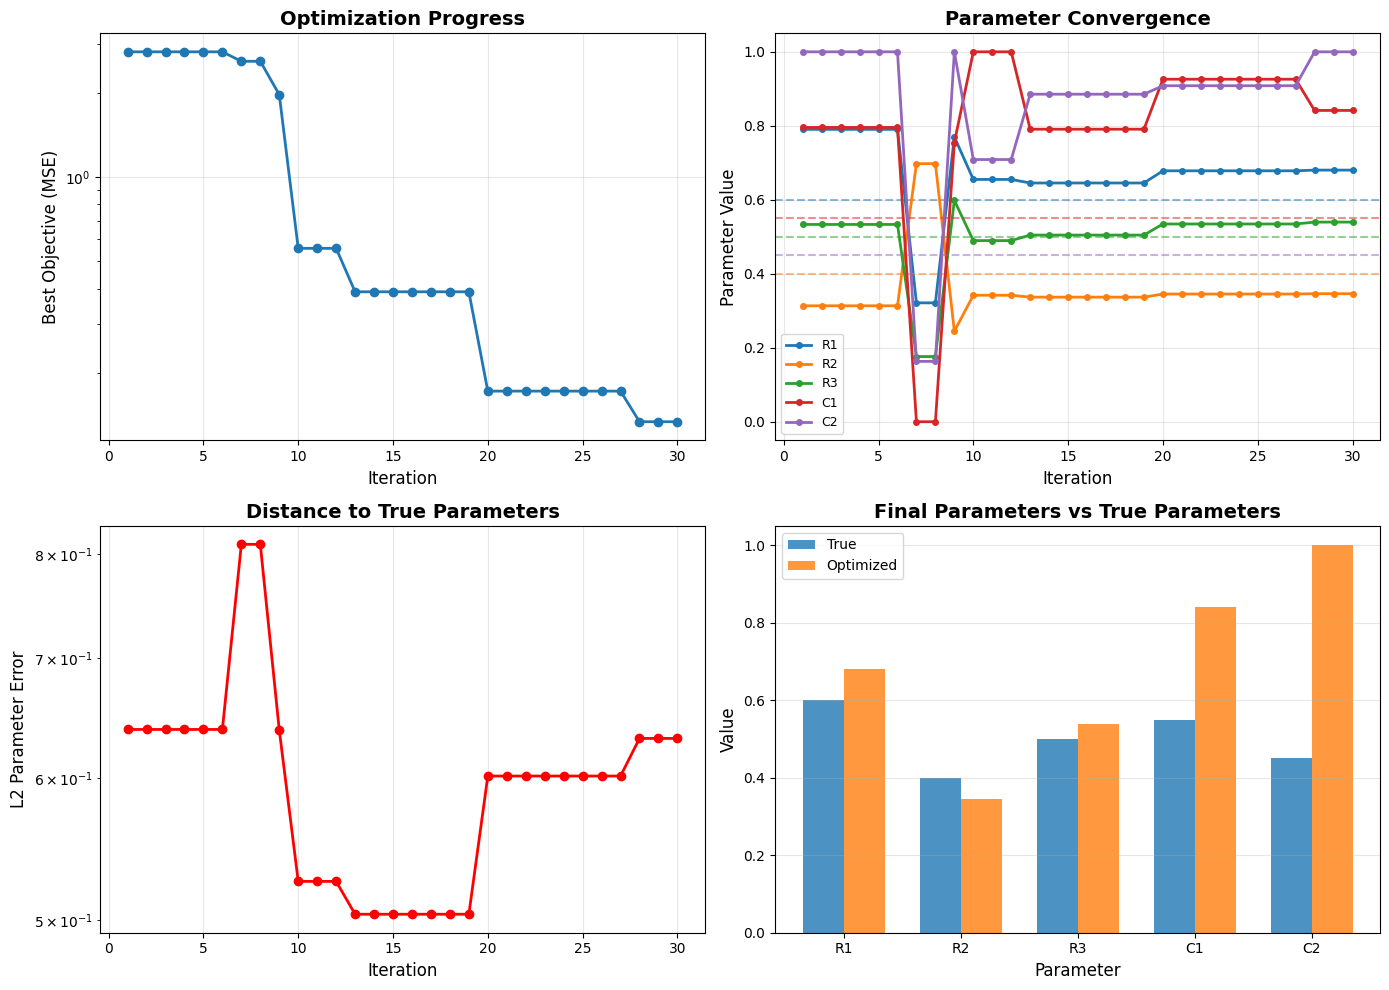

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Objective value over iterations
axes[0, 0].plot(range(1, n_iterations + 1), best_objectives, 'o-', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('Best Objective (MSE)', fontsize=12)
axes[0, 0].set_title('Optimization Progress', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Plot 2: Parameter convergence
best_params_array = np.array(best_params_history)
param_names = ['R1', 'R2', 'R3', 'C1', 'C2']
for i in range(5):
    axes[0, 1].plot(range(1, n_iterations + 1), best_params_array[:, i], 
                    'o-', label=param_names[i], linewidth=2, markersize=4,color=plt.cm.tab10(i))
    axes[0, 1].axhline(TRUE_PARAMS[i].item(),color=plt.cm.tab10(i), linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Iteration', fontsize=12)
axes[0, 1].set_ylabel('Parameter Value', fontsize=12)
axes[0, 1].set_title('Parameter Convergence', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Parameter error over iterations
param_errors = [np.linalg.norm(params - TRUE_PARAMS.numpy()) for params in best_params_history]
axes[1, 0].plot(range(1, n_iterations + 1), param_errors, 'o-', 
                linewidth=2, markersize=6, color='red')
axes[1, 0].set_xlabel('Iteration', fontsize=12)
axes[1, 0].set_ylabel('L2 Parameter Error', fontsize=12)
axes[1, 0].set_title('Distance to True Parameters', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Plot 4: Final parameter comparison
x_pos = np.arange(5)
final_params = best_params_history[-1]
true_params_np = TRUE_PARAMS.numpy()

width = 0.35
axes[1, 1].bar(x_pos - width/2, true_params_np, width, label='True', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, final_params, width, label='Optimized', alpha=0.8)
axes[1, 1].set_xlabel('Parameter', fontsize=12)
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_title('Final Parameters vs True Parameters', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(param_names)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Compare Predicted vs Target Measurements


Final Model Predictions vs Target Measurements

Measurement          Target       Predicted    Error       
----------------------------------------------------------------------
Q1 (Flow 1)            41.015 L/min   40.484 L/min    0.531 ( 1.29%)
Q2 (Flow 2)            27.916 L/min   27.789 L/min    0.127 ( 0.45%)
P1 (Pressure 1)        77.365 mmHg   75.964 mmHg    1.401 ( 1.81%)
P2 (Pressure 2)        41.497 mmHg   42.139 mmHg    0.642 ( 1.55%)


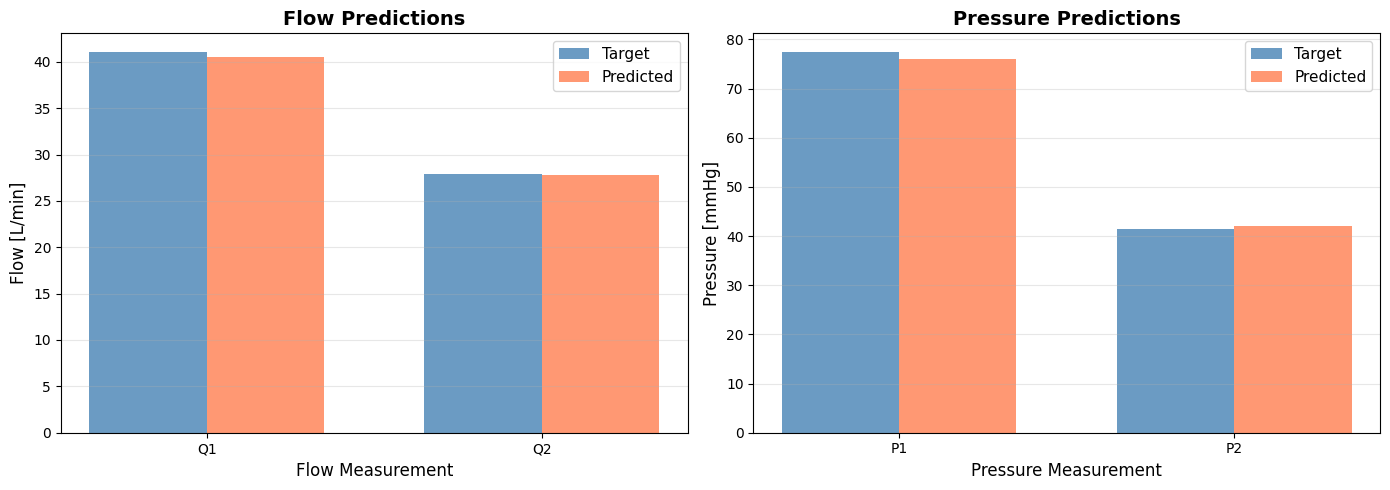

In [51]:
# Get final best parameters
final_params = torch.tensor(best_params_history[-1], **tkwargs)
final_params_with_fidelity = torch.cat([final_params, torch.ones(1, **tkwargs)], dim=0)

# Compute predictions
final_predictions = circulatory_model_multifidelity(final_params_with_fidelity)

# Print comparison
print("\n" + "="*70)
print("Final Model Predictions vs Target Measurements")
print("="*70)
measurement_names = ['Q1 (Flow 1)', 'Q2 (Flow 2)', 'P1 (Pressure 1)', 'P2 (Pressure 2)']
units = ['L/min', 'L/min', 'mmHg', 'mmHg']

print(f"\n{'Measurement':<20} {'Target':<12} {'Predicted':<12} {'Error':<12}")
print("-" * 70)
for i, (name, unit) in enumerate(zip(measurement_names, units)):
    target = target_measurements[i].item()
    pred = final_predictions[i].item()
    error = abs(pred - target)
    rel_error = (error / abs(target)) * 100
    print(f"{name:<20} {target:>8.3f} {unit:<3} {pred:>8.3f} {unit:<3} {error:>8.3f} ({rel_error:>5.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flows
flows_target = target_measurements[:2].numpy()
flows_pred = final_predictions[:2].numpy()
x_pos = np.arange(2)
width = 0.35

axes[0].bar(x_pos - width/2, flows_target, width, label='Target', alpha=0.8, color='steelblue')
axes[0].bar(x_pos + width/2, flows_pred, width, label='Predicted', alpha=0.8, color='coral')
axes[0].set_xlabel('Flow Measurement', fontsize=12)
axes[0].set_ylabel('Flow [L/min]', fontsize=12)
axes[0].set_title('Flow Predictions', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['Q1', 'Q2'])
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Pressures
pressures_target = target_measurements[2:].numpy()
pressures_pred = final_predictions[2:].numpy()

axes[1].bar(x_pos - width/2, pressures_target, width, label='Target', alpha=0.8, color='steelblue')
axes[1].bar(x_pos + width/2, pressures_pred, width, label='Predicted', alpha=0.8, color='coral')
axes[1].set_xlabel('Pressure Measurement', fontsize=12)
axes[1].set_ylabel('Pressure [mmHg]', fontsize=12)
axes[1].set_title('Pressure Predictions', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['P1', 'P2'])
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Summary

Part A of this notebook demonstrated multi-fidelity Bayesian Optimization for tuning a synthetic circulatory system model:

1. **Problem**: Tune 5 parameters (3 resistances + 2 compliances) to match 4 measurements (2 flows + 2 pressures)
2. **Approach**: Multi-fidelity GP trained on both low and high-fidelity data, with Expected Improvement optimizing only at high fidelity
3. **Results**: The optimizer efficiently finds parameters close to the true values, minimizing the mismatch between predictions and targets

The multi-fidelity approach allows leveraging cheap low-fidelity evaluations to build a better surrogate model, reducing the number of expensive high-fidelity evaluations needed.

## --- PART B --- Posterior Distribution Estimation using Approximate Bayesian Computation (ABC)

We will estimate the posterior distribution of parameters using ABC with the trained GP as an informed prior.

### Step 1: Define the informed prior distribution from the trained GP

In [52]:
# Get the best point from optimization (high-fidelity only)
# Note: train_y contains negated MSE values (BoTorch maximizes)
# So train_y.max() gives the best (least negative) value
high_fidelity_mask = train_X[:, 5] == 1.0
y_min = -train_y[high_fidelity_mask].max().item()  # Convert back to actual MSE
theta_min = train_X[high_fidelity_mask][train_y[high_fidelity_mask].argmax(), :-1]  # Exclude fidelity dimension

# Predict at theta_min to get sigma_min
# Need to add fidelity=1.0 for prediction
theta_min_with_fidelity = torch.cat([theta_min, torch.tensor([1.0], **tkwargs)])
with torch.no_grad():
    pred = model(theta_min_with_fidelity.unsqueeze(0))
    sigma_min_squared = pred.variance.item()
    y_min_gp = pred.mean.item()

# print(f"Best MSE found (high-fidelity): {y_min:.4f}")
print(f"Best MSE from GP: {y_min_gp}")
print(f"Best parameters: {theta_min}")
print(f"Prediction variance at best point: {sigma_min_squared:.6f}")

Best MSE from GP: 0.7250579685143994
Best parameters: tensor([0.6802, 0.3461, 0.5397, 0.8415, 1.0000], dtype=torch.float64)
Prediction variance at best point: 0.000102


### Step 2: Prior Distribution Sampling using Rejection Sampling

We define the prior probability density:
$$p(\theta) = \frac{1}{\sqrt{2\pi(\sigma_{GP}^2(\theta) + \sigma^2_{min})}} \exp\left(-\frac{(\mu_{GP}(\theta) - y_{min})^2}{2(\sigma_{GP}^2(\theta) + \sigma^2_{min})}\right)$$

In [53]:
# Generate N_s random samples and apply rejection sampling
N_s = 1000000  # Using fewer samples for demonstration (paper uses 5,000,000)

# Generate uniform random samples in parameter space
theta_samples = torch.rand(N_s, dim) * (bounds[1] - bounds[0]) + bounds[0]

# Add fidelity dimension (high fidelity = 1.0) for GP predictions
theta_samples_with_fidelity = torch.cat([theta_samples, torch.ones(N_s, 1, **tkwargs)], dim=1)

# Predict mean and variance for all samples
with torch.no_grad():
    predictions = model(theta_samples_with_fidelity)
    mu_theta = predictions.mean
    sigma_squared_theta = predictions.variance

# Compute prior probability for each sample (equation eq:prior)
prior_variance = sigma_squared_theta + sigma_min_squared
prior_prob = (1.0 / torch.sqrt(2 * np.pi * prior_variance)) * \
             torch.exp(-0.5 * ((mu_theta - y_min_gp) ** 2) / prior_variance)

# Find minimum variance across all samples for p_max calculation
min_variance = sigma_squared_theta.min().item()
p_max_variance = min_variance + sigma_min_squared
p_max = (1.0 / np.sqrt(2 * np.pi * p_max_variance)) * np.exp(0.0)  # exp(0) since mu=y_min

# Rejection sampling
uniform_samples = torch.rand(N_s) * p_max
accepted_mask = prior_prob.squeeze() > uniform_samples
prior_samples = theta_samples[accepted_mask]

print(f"Generated {N_s} samples, accepted {len(prior_samples)} from prior ({100*len(prior_samples)/N_s:.2f}%)")
print(f"p_max = {p_max:.6e}")

Generated 1000000 samples, accepted 2990 from prior (0.30%)
p_max = 2.844171e+01


### Step 3: Sort Prior Samples by Descending Probability

We sort the accepted samples by their prior probability to evaluate the most promising candidates first.

In [54]:
# Sort prior samples by descending prior probability
prior_prob_accepted = prior_prob.squeeze()[accepted_mask]
sorted_indices = torch.argsort(prior_prob_accepted, descending=True)
prior_samples_sorted = prior_samples[sorted_indices]
prior_prob_sorted = prior_prob_accepted[sorted_indices]

print(f"Top 5 prior probabilities: {prior_prob_sorted[:5].numpy()/p_max}")
print(f"Top prior sample (closest to theta_min):")
for i, name in enumerate(['R1', 'R2', 'R3', 'C1', 'C2']):
    print(f"  {name}: {prior_samples_sorted[0, i].item():.4f}")

Top 5 prior probabilities: [0.99735818 0.99669188 0.99179279 0.94669413 0.94277722]
Top prior sample (closest to theta_min):
  R1: 0.6774
  R2: 0.3197
  R3: 0.5314
  C1: 0.9066
  C2: 0.8849


### Step 4: ABC with MSE Distance

We use the MSE between predictions and measurements as the distance function. We accept samples if MSE is close to the best MSE found.

In [55]:
# ABC algorithm parameters
N_f = 30  # Number of final posterior samples to accept
tolerance_factor = 3  # Accept if MSE < tolerance_factor * y_min
max_consecutive_rejections = 50

posterior_samples = []
posterior_mse_values = []
consecutive_rejections = 0
samples_evaluated = 0

tolerance = tolerance_factor * y_min

print(f"Starting ABC algorithm to find {N_f} posterior samples...")
print(f"Best MSE: {y_min:.4f}")
print(f"Acceptance threshold: MSE < {tolerance:.4f} (factor: {tolerance_factor})")
print(f"Max consecutive rejections: {max_consecutive_rejections}")
print("-" * 70)

Starting ABC algorithm to find 30 posterior samples...
Best MSE: 0.1338
Acceptance threshold: MSE < 0.4015 (factor: 3)
Max consecutive rejections: 50
----------------------------------------------------------------------


### Step 5: Evaluate Candidates and Accept/Reject

We iterate through the sorted prior samples, evaluate each one, compute the MSE, and accept if below threshold.

In [56]:
# Define weights (same as in objective function)
weights = torch.tensor([1.0, 1.0, 0.1, 0.1], **tkwargs)

all_mse_values = []

# Iterate through sorted prior samples
for idx in range(len(prior_samples_sorted)):
    if len(posterior_samples) >= N_f:
        break
    
    theta_candidate = prior_samples_sorted[idx]
    samples_evaluated += 1
    
    # Add fidelity dimension (high fidelity = 1.0) for forward model evaluation
    theta_candidate_with_fidelity = torch.cat([theta_candidate, torch.tensor([1.0], **tkwargs)])
    
    # Evaluate the forward model for this candidate
    pred_at_candidate = circulatory_model_multifidelity(theta_candidate_with_fidelity)
    
    # Compute WEIGHTED MSE against target measurements (same as objective function)
    errors = (target_measurements - pred_at_candidate) ** 2
    weighted_mse = (weights * errors).mean().item()
    all_mse_values.append(weighted_mse)
    
    # Accept or reject based on tolerance
    if weighted_mse < tolerance:
        posterior_samples.append(theta_candidate)
        posterior_mse_values.append(weighted_mse)
        consecutive_rejections = 0
        print(f"✓ Accepted sample {len(posterior_samples)}/{N_f} | Weighted MSE: {weighted_mse:.4f}")
    else:
        consecutive_rejections += 1
        if samples_evaluated % 100 == 0:
            print(f"  Evaluated {samples_evaluated} samples, found {len(posterior_samples)}/{N_f} | Last weighted MSE: {weighted_mse:.4f}")
    
    # Check if we need to retrain GP (not implemented here for simplicity)
    if consecutive_rejections >= max_consecutive_rejections:
        print(f"⚠ Reached {max_consecutive_rejections} consecutive rejections. In full implementation, would retrain GP.")
        consecutive_rejections = 0  # Reset counter

posterior_samples = torch.stack(posterior_samples) if posterior_samples else torch.empty(0, dim)
print(f"\n{'='*70}")
print(f"ABC completed: {len(posterior_samples)} posterior samples obtained from {samples_evaluated} evaluations")
print(f"Acceptance rate: {100*len(posterior_samples)/samples_evaluated:.2f}%")
if len(posterior_mse_values) > 0:
    print(f"Weighted MSE range: [{min(posterior_mse_values):.4f}, {max(posterior_mse_values):.4f}]")

✓ Accepted sample 1/30 | Weighted MSE: 0.2036
✓ Accepted sample 2/30 | Weighted MSE: 0.2261
✓ Accepted sample 3/30 | Weighted MSE: 0.0728
✓ Accepted sample 4/30 | Weighted MSE: 0.2222
✓ Accepted sample 5/30 | Weighted MSE: 0.3525
✓ Accepted sample 6/30 | Weighted MSE: 0.1549
✓ Accepted sample 7/30 | Weighted MSE: 0.1833
✓ Accepted sample 8/30 | Weighted MSE: 0.3767
✓ Accepted sample 9/30 | Weighted MSE: 0.3082
✓ Accepted sample 10/30 | Weighted MSE: 0.0503
✓ Accepted sample 11/30 | Weighted MSE: 0.2574
✓ Accepted sample 12/30 | Weighted MSE: 0.2586
✓ Accepted sample 13/30 | Weighted MSE: 0.1611
✓ Accepted sample 14/30 | Weighted MSE: 0.3679
✓ Accepted sample 15/30 | Weighted MSE: 0.2961
✓ Accepted sample 16/30 | Weighted MSE: 0.0784
✓ Accepted sample 17/30 | Weighted MSE: 0.3835
✓ Accepted sample 18/30 | Weighted MSE: 0.3283
✓ Accepted sample 19/30 | Weighted MSE: 0.3315
✓ Accepted sample 20/30 | Weighted MSE: 0.3029
  Evaluated 100 samples, found 20/30 | Last weighted MSE: 1.4567
✓ Ac

### Step 6: Visualize Posterior Distribution

Plot the parameter distributions and compare them to the best point found during optimization.

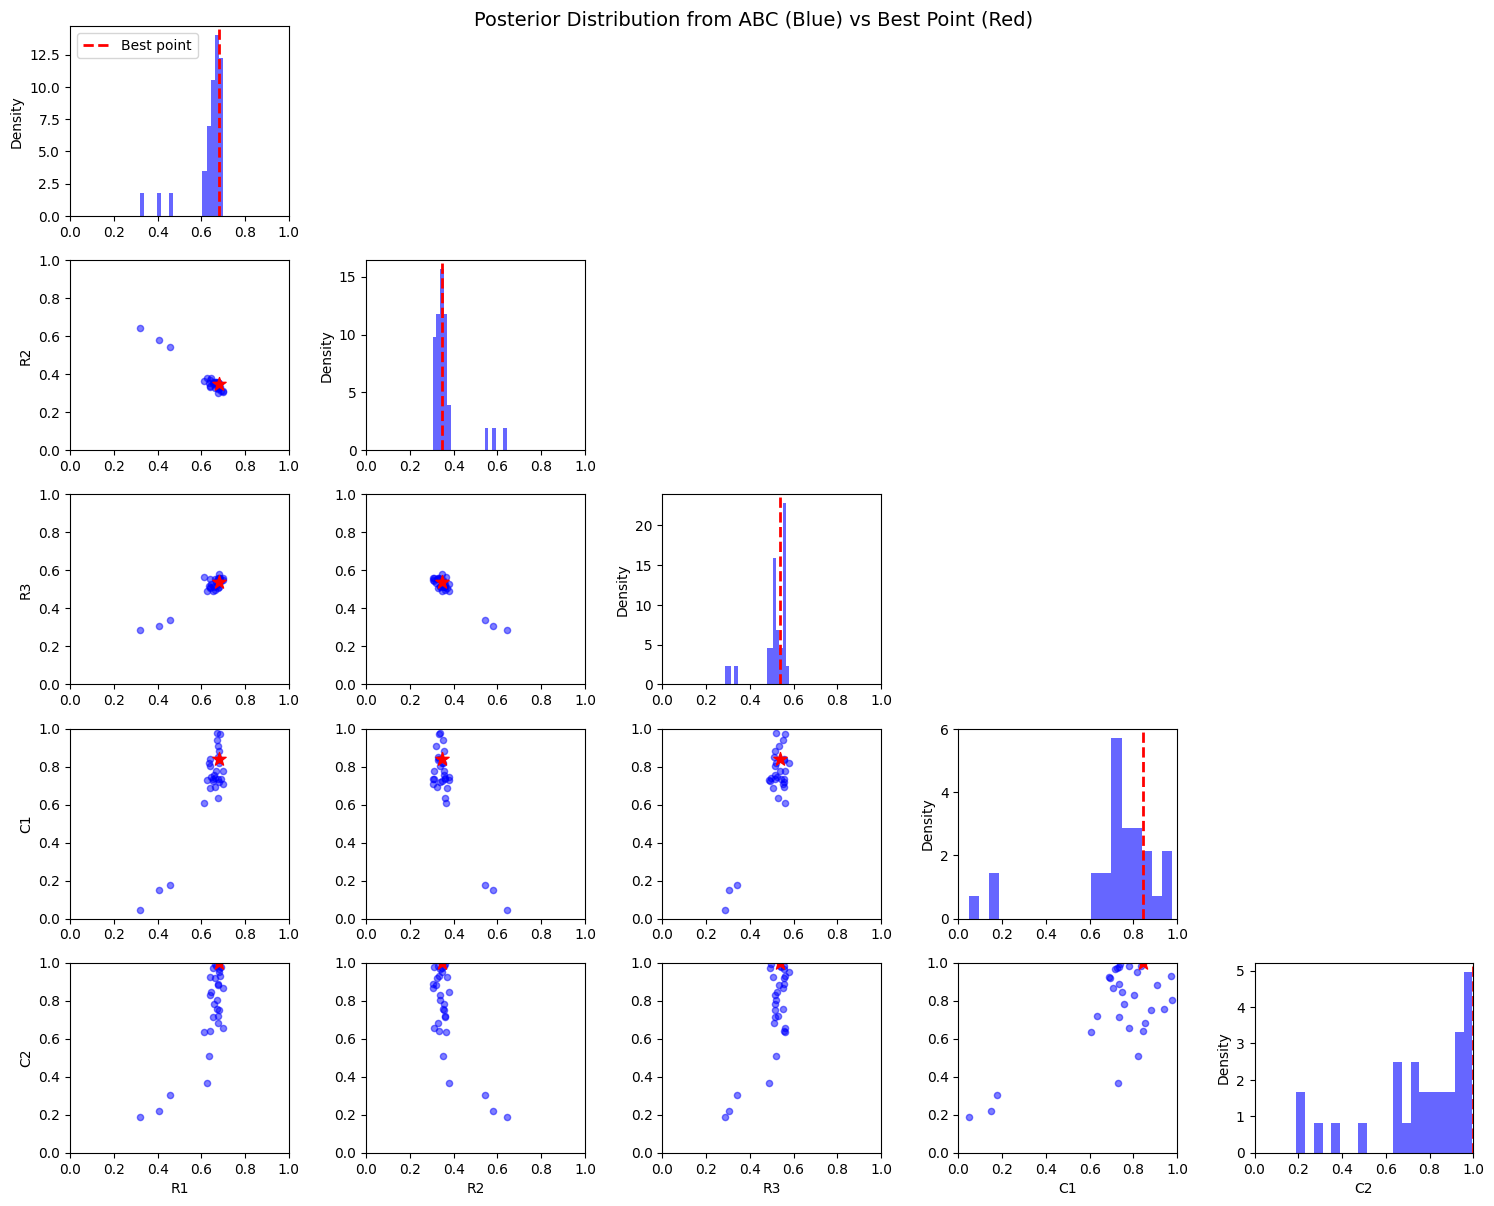

In [57]:
if len(posterior_samples) > 0:
    # Create pair plot
    fig, axes = plt.subplots(dim, dim, figsize=(15, 12))
    param_names = ['R1', 'R2', 'R3', 'C1', 'C2']
    
    for i in range(dim):
        for j in range(dim):
            ax = axes[i, j]
            
            if i == j:
                # Diagonal: histogram of parameter
                ax.hist(posterior_samples[:, i].numpy(), bins=20, alpha=0.6, color='blue', density=True)
                ax.axvline(theta_min[i].item(), color='red', linestyle='--', linewidth=2, label='Best point')
                ax.set_ylabel('Density')
                if i == 0:
                    ax.legend()
            elif i > j:
                # Lower triangle: scatter plot
                ax.scatter(posterior_samples[:, j].numpy(), posterior_samples[:, i].numpy(), 
                          alpha=0.5, s=20, color='blue')
                ax.scatter(theta_min[j].item(), theta_min[i].item(), 
                          color='red', s=100, marker='*', label='Best point')
                
                ax.set_ylim([0,1])
            else:
                # Upper triangle: empty
                ax.axis('off')

            ax.set_xlim([0,1])
            
            # Labels
            if i == dim - 1:
                ax.set_xlabel(param_names[j])
            if j == 0 and i != j:
                ax.set_ylabel(param_names[i])
    
    plt.tight_layout()
    plt.suptitle('Posterior Distribution from ABC (Blue) vs Best Point (Red)', y=1.001, fontsize=14)
    plt.show()
else:
    print("No posterior samples to visualize.")

### Step 7: Posterior Predictive Distribution

Generate predictions from all posterior samples to quantify uncertainty in the model output.

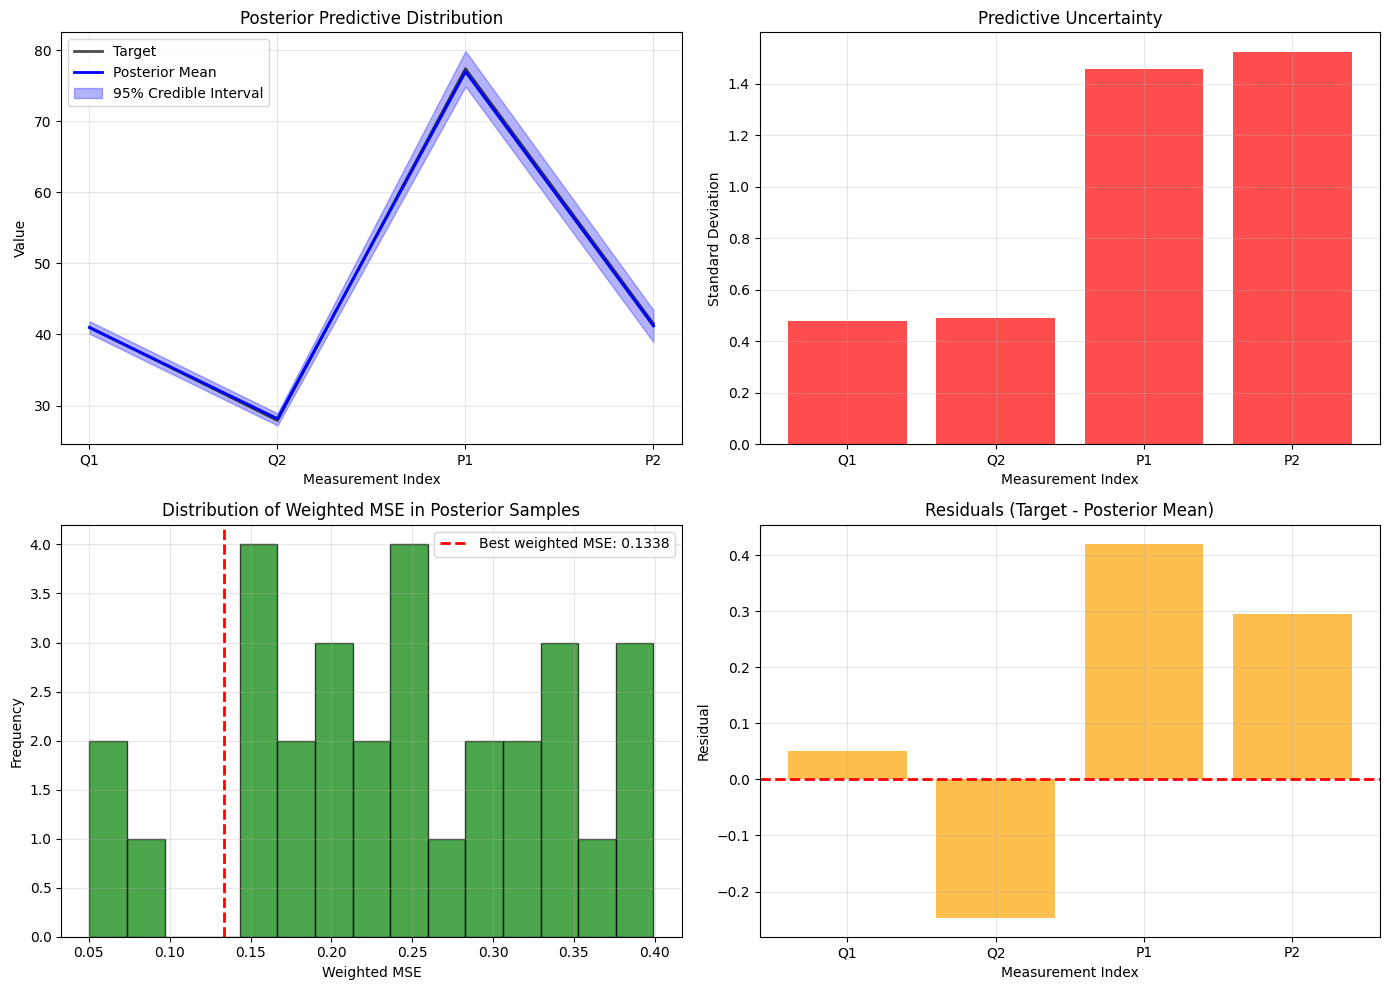


Posterior Predictive Statistics:
Mean weighted MSE: 0.2435 ± 0.0933
Best point weighted MSE: 0.1338


In [58]:
if len(posterior_samples) > 0:
    # Generate predictions from all posterior samples
    posterior_predictions = []
    
    for theta_post in posterior_samples:
        # Add fidelity dimension (high fidelity = 1.0)
        theta_post_with_fidelity = torch.cat([theta_post, torch.tensor([1.0], **tkwargs)])
        pred = circulatory_model_multifidelity(theta_post_with_fidelity)
        posterior_predictions.append(pred)
    
    posterior_predictions = torch.stack(posterior_predictions)
    
    # Compute statistics
    pred_mean = posterior_predictions.mean(dim=0)
    pred_std = posterior_predictions.std(dim=0)
    pred_lower = posterior_predictions.quantile(0.025, dim=0)
    pred_upper = posterior_predictions.quantile(0.975, dim=0)
    
    # Plot posterior predictive distribution
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    time_points = np.arange(len(pred_mean))
    
    axes[0, 0].plot(time_points, target_measurements.numpy(), 'k-', linewidth=2, label='Target', alpha=0.7)
    axes[0, 0].plot(time_points, pred_mean.numpy(), 'b-', linewidth=2, label='Posterior Mean')
    axes[0, 0].fill_between(time_points, pred_lower.numpy(), pred_upper.numpy(), 
                            alpha=0.3, color='blue', label='95% Credible Interval')
    axes[0, 0].set_xlabel('Measurement Index')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].set_title('Posterior Predictive Distribution')
    axes[0, 0].set_xticks(range(4))
    axes[0, 0].set_xticklabels(['Q1', 'Q2', 'P1', 'P2'])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot uncertainty for each measurement
    axes[0, 1].bar(time_points, pred_std.numpy(), color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Measurement Index')
    axes[0, 1].set_ylabel('Standard Deviation')
    axes[0, 1].set_title('Predictive Uncertainty')
    axes[0, 1].set_xticks(range(4))
    axes[0, 1].set_xticklabels(['Q1', 'Q2', 'P1', 'P2'])
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram of weighted MSE values across posterior samples
    axes[1, 0].hist(posterior_mse_values, bins=15, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].axvline(y_min, color='red', linestyle='--', linewidth=2, label=f'Best weighted MSE: {y_min:.4f}')
    axes[1, 0].set_xlabel('Weighted MSE')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Weighted MSE in Posterior Samples')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = (target_measurements - pred_mean).numpy()
    axes[1, 1].bar(time_points, residuals, alpha=0.7, color='orange')
    axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Measurement Index')
    axes[1, 1].set_ylabel('Residual')
    axes[1, 1].set_title('Residuals (Target - Posterior Mean)')
    axes[1, 1].set_xticks(range(4))
    axes[1, 1].set_xticklabels(['Q1', 'Q2', 'P1', 'P2'])
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPosterior Predictive Statistics:")
    print(f"Mean weighted MSE: {np.mean(posterior_mse_values):.4f} ± {np.std(posterior_mse_values):.4f}")
    print(f"Best point weighted MSE: {y_min:.4f}")
else:
    print("No posterior samples to generate predictions.")

### Step 8: Summary Statistics and Credible Intervals

In [ ]:
if len(posterior_samples) > 0:
    # Compute credible intervals for each parameter
    param_names = ['R1', 'R2', 'R3', 'C1', 'C2']
    
    print("\nPosterior Parameter Statistics:")
    print("=" * 80)
    print(f"{'Parameter':<12} {'Best Point':<12} {'Post. Mean':<12} {'Post. Std':<12} {'95% CI':<20}")
    print("-" * 80)
    
    for i, name in enumerate(param_names):
        best_val = theta_min[i].item()
        post_mean = posterior_samples[:, i].mean().item()* 2.0 + 0.5 # denormalizing
        post_std = posterior_samples[:, i].std().item()* 2.0 + 0.5 # denormalizing
        ci_lower = posterior_samples[:, i].quantile(0.025).item()* 2.0 + 0.5 # denormalizing
        ci_upper = posterior_samples[:, i].quantile(0.975).item()* 2.0 + 0.5 # denormalizing
        
        print(f"{name:<12} {best_val:<12.4f} {post_mean:<12.4f} {post_std:<12.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    print("=" * 80)
    print(f"\nParameter Uncertainty (Coefficient of Variation):")
    for i, name in enumerate(param_names):
        post_mean = posterior_samples[:, i].mean().item()* 2.0 + 0.5 # denormalizing
        post_std = posterior_samples[:, i].std().item()* 2.0 + 0.5 # denormalizing
        cv = post_std / post_mean if post_mean != 0 else float('inf')
        print(f"  {name}: {cv:.2%}")
else:
    print("No posterior samples for statistics.")


Posterior Parameter Statistics:
Parameter    Best Point   Post. Mean   Post. Std    95% CI              
--------------------------------------------------------------------------------
R1           0.6802       1.7745       0.6737       [1.2636, 1.8960]
R2           0.3461       1.2335       0.6581       [1.1087, 1.6942]
R3           0.5397       1.5221       0.6443       [1.1013, 1.6348]
C1           0.8415       1.9346       0.9420       [0.7418, 2.4482]
C2           1.0000       2.0101       0.9643       [0.9218, 2.4760]

Parameter Uncertainty (Coefficient of Variation):
  R1: 37.97%
  R2: 53.35%
  R3: 42.33%
  C1: 48.69%
  C2: 47.97%


## Summary

This implementation follows the Approximate Bayesian Computation (ABC) methodology described in Section 2.5 of the paper:

1. **Informed Prior from GP**: We use the trained Gaussian process from Bayesian optimization to define a prior distribution (Eq. eq:prior) that assigns higher probability to parameter values with low predicted loss and low uncertainty.

2. **Rejection Sampling**: We generate random samples and accept them based on the prior probability using rejection sampling. The paper uses N_s = 5,000,000 samples (we used fewer for demonstration).

3. **Distance Function**: We use MSE between predictions and measurements as the distance function for ABC acceptance.

4. **ABC Acceptance**: We accept samples if MSE < tolerance_factor × MSE_min, continuing until we collect N_f = 30 posterior samples.

5. **Posterior Analysis**: The resulting posterior distribution captures parameter uncertainty and can be used for making predictions with credible intervals.

**Key features:**
- Uses the optimization GP as an informed prior (not a true Bayesian prior)
- Simple MSE-based acceptance criterion
- Provides interpretable uncertainty quantification for clinical decision-making
- Sorted evaluation ensures most promising candidates are evaluated first